In [1]:
!pip -q install timm opencv-python scikit-image albumentations==1.4.4 tqdm imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 27.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:0000:0100:06m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━

In [2]:
from pathlib import Path
import random, numpy as np, torch

# Which pseudo-mask method to use for the WSSS training/eval stage
PSEUDO_METHOD = "gradcam"   # options: 'gradcam' or 'attnroll'

# Full-set run (no subset slicing)
MAX_TRAIN = None             # None => use full trainval; set an int to limit
BATCH_TRAIN = 8
BATCH_VAL   = 8
IMG_SIZE    = 256
SEED        = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

OUTPUT     = Path("/kaggle/working/outputs")
SEEDS_DIR  = OUTPUT / "seeds"
RESULTS    = OUTPUT
PSEUDO_DIR = OUTPUT / "pseudo_masks" / PSEUDO_METHOD
CKPT_PATH  = RESULTS / f"deeplab_binary_{PSEUDO_METHOD}_best.pth"
PERIMG_CSV = RESULTS / f"val_perimage_metrics_{PSEUDO_METHOD}.csv"

SEEDS_DIR.mkdir(parents=True, exist_ok=True)
PSEUDO_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def find_voc_root():
    base = Path("/kaggle/input/pascal-voc-2012-dataset")
    cand = [
        base/"VOC2012_train_val"/"VOC2012_train_val",
        base/"VOC2012_train_val",
        base/"VOC2012",
        base/"VOCdevkit"/"VOC2012",
    ]
    for p in cand:
        if p.is_dir():
            return p
    raise FileNotFoundError("Could not locate VOC2012 root under Kaggle input.")

VOC_ROOT = find_voc_root()
IMG_ROOT = VOC_ROOT / "JPEGImages"
GT_ROOT  = VOC_ROOT / "SegmentationClass"
IMGSETS  = VOC_ROOT / "ImageSets" / "Segmentation"
print("VOC_ROOT:", VOC_ROOT)
print({
    'JPEGImages': IMG_ROOT.exists(),
    'SegmentationClass': GT_ROOT.exists(),
    'ImageSets/Segmentation': IMGSETS.exists()
})

VOC_ROOT: /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val
{'JPEGImages': True, 'SegmentationClass': True, 'ImageSets/Segmentation': True}


In [4]:
# Read train/val image ids
train_ids = (IMGSETS/"train.txt").read_text().splitlines()
val_ids   = (IMGSETS/"val.txt").read_text().splitlines()

print(f"Train size: {len(train_ids)}")
print(f"Val size:   {len(val_ids)}")

# If MAX_TRAIN is set, cut down
if MAX_TRAIN is not None:
    train_ids = train_ids[:MAX_TRAIN]

len(train_ids), len(val_ids)

Train size: 1464
Val size:   1449


(1464, 1449)

In [5]:
import torch
from torchvision import transforms as T
from PIL import Image
import torchvision.models as tvm
import timm

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE:', DEVICE)

# ImageNet normalization @ 224
preprocess = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# ResNet-50 (for Grad-CAM)
resnet = tvm.resnet50(weights=tvm.ResNet50_Weights.IMAGENET1K_V2).to(DEVICE).eval()

# ViT-B/16 (for attention rollout)
vit = timm.create_model('vit_base_patch16_224', pretrained=True).to(DEVICE).eval()

print('Models loaded.')

DEVICE: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Models loaded.


In [6]:
import numpy as np, cv2
from torchvision.transforms import functional as TF
import torchvision.transforms as VT

def perturbations(img):
    out = {}
    img224 = TF.resize(img, (224,224))
    out['hflip'] = TF.hflip(img224)
    out['rotation'] = img224.rotate(30, resample=Image.BILINEAR)

    a = cv2.cvtColor(np.array(img224), cv2.COLOR_RGB2BGR)
    a = cv2.GaussianBlur(a, (5,5), 0)
    out['blur'] = Image.fromarray(cv2.cvtColor(a, cv2.COLOR_BGR2RGB))

    out['brightness'] = VT.functional.adjust_brightness(img224, 1.5)

    b = np.array(img224).astype(np.float32)/255.0
    b += np.random.normal(0,0.1,b.shape).astype(np.float32)
    b = np.clip(b,0,1)
    out['gauss'] = Image.fromarray((b*255).astype(np.uint8))
    return out

print('Perturb helpers ready.')

Perturb helpers ready.


In [8]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients  = None
        def fwd_hook(m, i, o): self.activations = o.detach()
        def bwd_hook(m, gi, go): self.gradients = go[0].detach()
        self.h1 = target_layer.register_forward_hook(fwd_hook)
        self.h2 = target_layer.register_backward_hook(bwd_hook)
    def __call__(self, x):
        self.model.zero_grad()
        out = self.model(x)
        idx = out.argmax(1)
        loss = out[torch.arange(out.size(0)), idx].sum()
        loss.backward()
        acts = self.activations
        grads = self.gradients
        w = grads.mean(dim=(2,3), keepdim=True)
        cam = (w*acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
        cam = cam - cam.min(); cam = cam/(cam.max()+1e-8)
        return cam.squeeze(1).detach().cpu().numpy()
    def close(self): self.h1.remove(); self.h2.remove()

gradcam = GradCAM(resnet, resnet.layer4[-1])
print('GradCAM ready.')

GradCAM ready.


In [9]:
import math, torch
import numpy as np, cv2

def vit_attention_rollout(model, x, head_fusion="mean"):
    qkv_per_layer, hooks = [], []
    def hook_qkv(m, inp, out): qkv_per_layer.append(out.detach().cpu())
    for blk in model.blocks:
        hooks.append(blk.attn.qkv.register_forward_hook(hook_qkv))
    with torch.no_grad(): _ = model(x)
    [h.remove() for h in hooks]
    if len(qkv_per_layer)==0:
        raise RuntimeError('No qkv captured; check model type')
    att_layers = []
    for qkv in qkv_per_layer:
        B,N,threeC = qkv.shape; assert B==1
        H = model.blocks[0].attn.num_heads
        D = (threeC//3)//H
        qkv = qkv.reshape(B,N,3,H,D).permute(2,0,3,1,4)
        q,k = qkv[0], qkv[1]
        att = (q @ k.transpose(-2,-1))/math.sqrt(D)
        att = torch.softmax(att, dim=-1)
        att = att.mean(dim=1)[0] if head_fusion=='mean' else att.max(dim=1)[0][0]
        eye = torch.eye(att.size(-1))
        att = att + eye
        att = att/att.sum(dim=-1, keepdim=True)
        att_layers.append(att)
    joint = att_layers[0]
    for l in range(1,len(att_layers)): joint = att_layers[l] @ joint
    vec = joint[0]   # CLS to all
    grid = vec[1:]
    m = int(round(math.sqrt(len(grid))))
    if m*m != len(grid):
        grid = vec[2:]
        m = int(round(math.sqrt(len(grid))))
        if m*m != len(grid): raise ValueError('Cannot square-reshape attention vector')
    hm = grid.reshape(m,m).numpy()
    hm = (hm-hm.min())/(hm.max()-hm.min()+1e-8)
    hm = cv2.resize(hm, (224,224), interpolation=cv2.INTER_LINEAR)
    return hm

print('ViT rollout ready.')

ViT rollout ready.


In [10]:
import imageio, os
from tqdm import tqdm

def save_gray(arr, path):
    path = Path(path); path.parent.mkdir(parents=True, exist_ok=True)
    imageio.v2.imwrite(path, (arr*255).astype(np.uint8))

def voc_img_path(img_id): return IMG_ROOT / f"{img_id}.jpg"

def generate_seeds_for_id(img_id, do_resnet=True, do_vit=True):
    img = Image.open(voc_img_path(img_id)).convert('RGB')
    # clean
    if do_resnet:
        op = SEEDS_DIR/"resnet_gradcam"/f"{img_id}_clean.png"
        if not op.exists():
            x = preprocess(img).unsqueeze(0).to(DEVICE)
            cam = gradcam(x)[0]
            save_gray(cam, op)
    if do_vit:
        op = SEEDS_DIR/"vit_attnroll"/f"{img_id}_clean.png"
        if not op.exists():
            x = preprocess(img).unsqueeze(0).to(DEVICE)
            hm = vit_attention_rollout(vit, x)
            save_gray(hm, op)
    # perturbations
    perts = perturbations(img)
    for name, pimg in perts.items():
        if do_resnet:
            op = SEEDS_DIR/"resnet_gradcam"/f"{img_id}_{name}.png"
            if not op.exists():
                x = preprocess(pimg).unsqueeze(0).to(DEVICE)
                cam = gradcam(x)[0]
                save_gray(cam, op)
        if do_vit:
            op = SEEDS_DIR/"vit_attnroll"/f"{img_id}_{name}.png"
            if not op.exists():
                x = preprocess(pimg).unsqueeze(0).to(DEVICE)
                hm = vit_attention_rollout(vit, x)
                save_gray(hm, op)

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

# Trainval seeds (for pseudo labels)
for part, id_chunk in enumerate(chunks(train_ids, 200), start=1):
    for img_id in tqdm(id_chunk, desc=f"seeds trainval chunk {part}"):
        generate_seeds_for_id(img_id, do_resnet=True, do_vit=True)
    print("done chunk", part)

# Val seeds (for robustness metrics)
for part, id_chunk in enumerate(chunks(val_ids, 200), start=1):
    for img_id in tqdm(id_chunk, desc=f"seeds val chunk {part}"):
        generate_seeds_for_id(img_id, do_resnet=True, do_vit=True)
    print("done chunk", part)

print('Seed generation complete.')

seeds trainval chunk 1:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
seeds trainval chunk 1: 100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


done chunk 1


seeds trainval chunk 2: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


done chunk 2


seeds trainval chunk 3: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


done chunk 3


seeds trainval chunk 4: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


done chunk 4


seeds trainval chunk 5: 100%|██████████| 200/200 [01:23<00:00,  2.40it/s]


done chunk 5


seeds trainval chunk 6: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


done chunk 6


seeds trainval chunk 7: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


done chunk 7


seeds trainval chunk 8: 100%|██████████| 64/64 [00:27<00:00,  2.36it/s]


done chunk 8


seeds val chunk 1: 100%|██████████| 200/200 [01:24<00:00,  2.38it/s]


done chunk 1


seeds val chunk 2: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


done chunk 2


seeds val chunk 3: 100%|██████████| 200/200 [01:24<00:00,  2.38it/s]


done chunk 3


seeds val chunk 4: 100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


done chunk 4


seeds val chunk 5: 100%|██████████| 200/200 [01:24<00:00,  2.35it/s]


done chunk 5


seeds val chunk 6: 100%|██████████| 200/200 [01:24<00:00,  2.38it/s]


done chunk 6


seeds val chunk 7: 100%|██████████| 200/200 [01:23<00:00,  2.39it/s]


done chunk 7


seeds val chunk 8: 100%|██████████| 49/49 [00:20<00:00,  2.39it/s]

done chunk 8
Seed generation complete.


In [16]:
# --- Seed robustness on FULL val set (resumable, safe, numeric-only) ---

import pandas as pd, numpy as np, imageio
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

# paths & lists from earlier cells:
# SEEDS_DIR, RESULTS, val_ids  (note: lower-case 'val_ids')

SEED_ROB_CSV = RESULTS / "seed_similarity_full.csv"

# create header once (resumable)
if not SEED_ROB_CSV.exists():
    pd.DataFrame(columns=["id","method","perturb","IoU","SSIM"]).to_csv(SEED_ROB_CSV, index=False)

# helper io
def load_gray(p):
    if not p.exists(): 
        return None
    a = imageio.v2.imread(p).astype("float32")/255.0
    if a.ndim == 3: a = a[...,0]
    return a

def binarize(a, th=0.30): 
    return (a >= th).astype("uint8")

def iou(a,b):
    inter = (a & b).sum(); union = (a | b).sum()
    return float(inter) / (float(union) + 1e-8)

# resume set
done = set()
try:
    df_done = pd.read_csv(SEED_ROB_CSV, usecols=["id","method","perturb"])
    done = set(map(tuple, df_done.values))
except Exception:
    pass

def append_rows(rows):
    if rows:
        pd.DataFrame(rows).to_csv(SEED_ROB_CSV, mode="a", header=False, index=False)

METHOD_DIR = {
    "resnet_gradcam": SEEDS_DIR / "resnet_gradcam",
    "vit_attnroll":   SEEDS_DIR / "vit_attnroll",
}

PERTS = ["hflip","rotation","blur","brightness","gauss"]

for method, mdir in METHOD_DIR.items():
    for img_id in tqdm(val_ids, desc=f"seed-robust {method}"):
        c = load_gray(mdir / f"{img_id}_clean.png")
        if c is None:           # seed missing -> skip all perts
            continue
        cb = binarize(c, 0.30)

        rows = []
        for p in PERTS:
            key = (img_id, method, p)
            if key in done:      # already measured
                continue
            t = load_gray(mdir / f"{img_id}_{p}.png")
            if t is None:
                continue
            tb = binarize(t, 0.30)
            rows.append({
                "id": img_id,
                "method": method,
                "perturb": p,
                "IoU": iou(cb, tb),
                "SSIM": ssim(c, t, data_range=1.0)
            })
            done.add(key)
        append_rows(rows)

print("Saved full robustness CSV:", SEED_ROB_CSV.resolve())

# numeric-only summary for quick view
df = pd.read_csv(SEED_ROB_CSV)
for col in ["IoU","SSIM"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["IoU","SSIM"])
summary = df.groupby(["method","perturb"])[["IoU","SSIM"]].mean().round(3)
display(summary)

seed-robust vit_attnroll: 100%|██████████| 1449/1449 [00:01<00:00, 827.64it/s]

Saved full robustness CSV: /kaggle/working/outputs/seed_similarity_full.csv


IoU   SSIM
method         perturb                 
resnet_gradcam blur        0.673  0.748
               brightness  0.790  0.857
               gauss       0.580  0.651
               hflip       0.454  0.561
               rotation    0.511  0.584
vit_attnroll   blur        0.679  0.928
               brightness  0.498  0.819
               gauss       0.502  0.815
               hflip       0.239  0.580
               rotation    0.220  0.514

In [17]:
from imageio import v2 as iio

def seeds_to_pseudo(ids, method='gradcam', th=0.3):
    src = SEEDS_DIR / ({'gradcam':'resnet_gradcam','attnroll':'vit_attnroll'}[method])
    PSEUDO_DIR.mkdir(parents=True, exist_ok=True)
    for img_id in ids:
        s = src / f"{img_id}_clean.png"
        if not s.exists(): 
            continue  # skip missing seeds
        c = imageio.v2.imread(s).astype("float32")/255.0
        if c.ndim==3: c = c[...,0]
        mask = (c>=th).astype("uint8")*255  # binary FG/BG
        iio.imwrite(PSEUDO_DIR/f"{img_id}.png", mask)
    print("Pseudo masks written to:", PSEUDO_DIR)

seeds_to_pseudo(train_ids, method=PSEUDO_METHOD, th=0.3)

Pseudo masks written to: /kaggle/working/outputs/pseudo_masks/gradcam


In [37]:
import os, math, gc, sys, warnings
from pathlib import Path
import numpy as np
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [38]:
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VOC_ROOT    = Path(VOC_ROOT) if 'VOC_ROOT' in globals() else Path("/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val")
IMG_ROOT    = Path(IMG_ROOT) if 'IMG_ROOT' in globals() else (VOC_ROOT / "JPEGImages")
GT_ROOT     = Path(GT_ROOT)  if 'GT_ROOT'  in globals() else (VOC_ROOT / "SegmentationClass")
PSEUDO_DIR  = Path(PSEUDO_DIR) if 'PSEUDO_DIR' in globals() else (Path.cwd() / "outputs" / "pseudo_masks")
RESULTS     = Path(RESULTS) if 'RESULTS' in globals() else (Path.cwd() / "outputs")
RESULTS.mkdir(parents=True, exist_ok=True)
CKPT_PATH   = RESULTS / "deeplab_binary_best.pth"

IMG_SIZE    = int(IMG_SIZE) if 'IMG_SIZE' in globals() else 256
BATCH_TRAIN = int(BATCH_TRAIN) if 'BATCH_TRAIN' in globals() else 8
BATCH_VAL   = int(BATCH_VAL) if 'BATCH_VAL' in globals() else 8
EPOCHS      = int(EPOCHS) if 'EPOCHS' in globals() else 15
PATIENCE    = 3
IGNORE_IDX  = 255

In [39]:
def _read_ids(txt):
    return [x.strip() for x in open(txt) if x.strip()]

if 'train_ids' not in globals():
    split_train = VOC_ROOT / "ImageSets" / "Segmentation" / "train.txt"
    if not split_train.exists():
        # some mirrors name it 'trainval.txt' – fallback
        split_train = VOC_ROOT / "ImageSets" / "Segmentation" / "trainval.txt"
    train_ids = _read_ids(split_train)

if 'val_ids' not in globals():
    split_val = VOC_ROOT / "ImageSets" / "Segmentation" / "val.txt"
    val_ids   = _read_ids(split_val)

print(f"IDs -> train: {len(train_ids)}  val: {len(val_ids)}")
print("Roots:", IMG_ROOT, GT_ROOT, "\nPseudo:", PSEUDO_DIR)

IDs -> train: 1464  val: 1449
Roots: /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages /kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/SegmentationClass 
Pseudo: /kaggle/working/outputs/pseudo_masks/gradcam


In [40]:
class VOCPseudoBinary(Dataset):
    """
    Returns: x (FloatTensor CxSxS), y (LongTensor SxS in {0,1}), g (LongTensor SxS in {0,1,255}), id (str)
    Uses pseudo masks as supervision; GT only for eval metrics.
    """
    def __init__(self, ids, img_root, pseudo_root, gt_root, train: bool, size: int = 256):
        self.ids = list(ids)
        self.img_root   = Path(img_root)
        self.pseudo_root= Path(pseudo_root)
        self.gt_root    = Path(gt_root)
        self.train      = bool(train)
        self.size       = int(size)

        # aug pipelines
        aug_train = [
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussianBlur(blur_limit=(3,5), p=0.15),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=15,
                               border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
            A.Resize(self.size, self.size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ]
        
        aug_val = [
            A.Resize(self.size, self.size),
            A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
            ToTensorV2()
        ]
        self.tr = A.Compose(aug_train if self.train else aug_val)

    def __len__(self): 
        return len(self.ids)

    def __getitem__(self, i):
        img_id = self.ids[i]

        # --- read image
        img_path = self.img_root / f"{img_id}.jpg"
        if not img_path.exists():
            # some VOC mirrors are .jpeg
            alt = self.img_root / f"{img_id}.jpeg"
            if alt.exists(): img_path = alt
        img = np.array(Image.open(img_path).convert("RGB"))
        # --- read pseudo (may be missing)
        p_path = self.pseudo_root / f"{img_id}.png"
        if p_path.exists():
            pm = np.array(Image.open(p_path).convert("L"))
        else:
            # fallback: empty pseudo (all background)
            pm = np.zeros(img.shape[:2], np.uint8)

        # --- read GT (for eval); if missing, fallback to ignore all
        g_path = self.gt_root / f"{img_id}.png"
        if g_path.exists():
            gt = np.array(Image.open(g_path).convert("L"))
        else:
            gt = np.full(img.shape[:2], IGNORE_IDX, np.uint8)

        # --- ensure SAME HxW before Albumentations (prevents shape errors)
        H, W = img.shape[:2]
        if pm.shape[:2] != (H, W):
            pm = cv2.resize(pm, (W, H), interpolation=cv2.INTER_NEAREST)
        if gt.shape[:2] != (H, W):
            gt = cv2.resize(gt, (W, H), interpolation=cv2.INTER_NEAREST)

        # pseudo to {0,255}; GT keep 255 as ignore, else {0,1}
        pm = (pm > 0).astype(np.uint8) * 255
        gt = np.where(gt == IGNORE_IDX, IGNORE_IDX, (gt > 0).astype(np.uint8))
        # --- joint transforms (ToTensorV2 returns tensors)
        aug = self.tr(image=img, masks=[pm, gt])
        x   = aug["image"].float()
        pm2, gt2 = aug["masks"]

        # masks may be numpy or tensors depending on Albumentations version
        if isinstance(pm2, torch.Tensor):
            y = (pm2 > 0).to(torch.long).squeeze(0) if pm2.ndim == 3 else (pm2 > 0).to(torch.long)
        else:
            y = torch.from_numpy((pm2 > 0).astype(np.int64))

        if isinstance(gt2, torch.Tensor):
            g = gt2.to(torch.long).squeeze(0) if gt2.ndim == 3 else gt2.to(torch.long)
        else:
            g = torch.from_numpy(gt2.astype(np.int64))

        return x, y, g, img_id
        



In [41]:
def make_loaders(nw=0, pin=False):
    train_dl = DataLoader(
        VOCPseudoBinary(train_ids, IMG_ROOT, PSEUDO_DIR, GT_ROOT, train=True,  size=IMG_SIZE),
        batch_size=BATCH_TRAIN, shuffle=True, num_workers=nw, pin_memory=pin, persistent_workers=False
    )
    val_dl = DataLoader(
        VOCPseudoBinary(val_ids,   IMG_ROOT, PSEUDO_DIR, GT_ROOT, train=False, size=IMG_SIZE),
        batch_size=BATCH_VAL, shuffle=False, num_workers=nw, pin_memory=pin, persistent_workers=False
    )
    return train_dl, val_dl

train_dl, val_dl = make_loaders(nw=0, pin=False)  # reveal errors first
bx, by, bg, bids = next(iter(train_dl))
print("DEBUG shapes:", tuple(bx.shape), tuple(by.shape), tuple(bg.shape), "…OK")

# switch to faster loaders
train_dl, val_dl = make_loaders(nw=2, pin=True)
print("batches -> train:", len(train_dl), "val:", len(val_dl))

DEBUG shapes: (8, 3, 256, 256) (8, 256, 256) (8, 256, 256) …OK
batches -> train: 183 val: 182


In [42]:
import torchvision
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def build_deeplab_binary(num_classes=2):
    # Try to load ImageNet backbone; fall back gracefully if API differs
    try:
        from torchvision.models import ResNet50_Weights
        m = torchvision.models.segmentation.deeplabv3_resnet50(
            weights=None, weights_backbone=ResNet50_Weights.IMAGENET1K_V1
        )
    except Exception:
        try:
            m = torchvision.models.segmentation.deeplabv3_resnet50(weights_backbone="IMAGENET1K_V1")
        except Exception:
            m = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)

    # >>> Correct in-channels for ResNet-50 backbone is 2048 <<<
    m.classifier = DeepLabHead(2048, num_classes)

    # (optional) remove aux head to avoid extra loss/params
    if hasattr(m, "aux_classifier"):
        m.aux_classifier = None
    return m

In [43]:
def fast_confusion(pred, target, num_classes=2, ignore_index=IGNORE_IDX):
    """
    pred: (B,H,W) int64 in [0..C-1]
    target: (B,H,W) int64 with ignore_index
    """
    with torch.no_grad():
        mask = target != ignore_index
        pred = pred[mask]
        target = target[mask]
        cm = torch.bincount(
            (target * num_classes + pred).view(-1),
            minlength=num_classes * num_classes
        ).reshape(num_classes, num_classes).to(torch.float32)
    return cm

In [45]:
def iou_from_cm(cm):
    # cm: CxC
    eps = 1e-7
    tp = cm.diag()
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    iou = (tp + eps) / (tp + fp + fn + eps)
    miou = iou.mean().item()
    return iou.cpu().numpy().tolist(), miou


def evaluate(dl):
    model.eval()
    cm = torch.zeros(2,2, device=DEVICE)
    with torch.no_grad():
        for x, _, g, _ in dl:
            x, g = x.to(DEVICE, non_blocking=True), g.to(DEVICE, non_blocking=True)
            out = model(x)["out"]                      # Bx2xHxW
            pred = out.argmax(1)                       # BxHxW
            cm += fast_confusion(pred, g, num_classes=2, ignore_index=IGNORE_IDX)
    ious, miou = iou_from_cm(cm)
    return {"IoU_bg": ious[0], "IoU_fg": ious[1], "mIoU": miou}

In [48]:
try:
    del model
except NameError:
    pass
torch.cuda.empty_cache()

import torchvision
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def build_deeplab_binary(num_classes=2):
    # build base model
    try:
        from torchvision.models import ResNet50_Weights
        m = torchvision.models.segmentation.deeplabv3_resnet50(
            weights=None, weights_backbone=ResNet50_Weights.IMAGENET1K_V1
        )
    except Exception:
        try:
            m = torchvision.models.segmentation.deeplabv3_resnet50(weights_backbone="IMAGENET1K_V1")
        except Exception:
            m = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)

    in_ch = getattr(m.backbone, "out_channels", 2048)
    # replace classifier with correct in_ch
    m.classifier = DeepLabHead(in_ch, num_classes)
    # drop aux head if present
    if hasattr(m, "aux_classifier"):
        m.aux_classifier = None
    return m

model = build_deeplab_binary(2).to(DEVICE)
model.eval()

print("Backbone out_channels:", getattr(model.backbone, "out_channels", "NA"))
print("Head first conv weight shape:",
      next(model.classifier.modules()).weight.shape if hasattr(next(model.classifier.modules()), "weight") else "NA")

# For torchvision’s DeepLabHead, the first conv inside ASPP should be [256, 2048, 1, 1]
# (out_channels=256, in_channels=2048)
# Let’s search explicitly for a 1x1 conv inside the ASPP and print its in_channels:
for m in model.classifier.modules():
    if isinstance(m, torch.nn.Conv2d) and m.kernel_size == (1,1):
        print("Found 1x1 conv weight:", tuple(m.weight.shape))
        break

# ---- dummy forward to confirm no channel error
with torch.no_grad():
    dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=DEVICE)
    out = model(dummy)["out"]
    print("Dummy forward ok:", tuple(out.shape))

Backbone out_channels: NA
Head first conv weight shape: NA
Found 1x1 conv weight: (256, 2048, 1, 1)
Dummy forward ok: (1, 2, 256, 256)


In [49]:
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_IDX)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

/tmp/ipykernel_36/814338592.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [51]:
def train_one_epoch():
    model.train()
    total = 0.0
    for x, y, _, _ in train_dl:  # supervise with pseudo y; ignore g here
        x, y = x.to(DEVICE, non_blocking=True), y.to(DEVICE, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            out = model(x)["out"]                  # Bx2xHxW
            loss = criterion(out, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        total += loss.item()
    return total / max(1, len(train_dl))

best_miou, wait = 0.0, 0
for ep in range(1, EPOCHS+1):
    tl = train_one_epoch()
    mets = evaluate(val_dl)
    sched.step()
    print(f"Epoch {ep:>2}/{EPOCHS} | loss={tl:.4f} | mIoU={mets['mIoU']:.3f}  (bg={mets['IoU_bg']:.3f}, fg={mets['IoU_fg']:.3f})")
    if mets["mIoU"] > best_miou + 1e-4:
        best_miou = mets["mIoU"]; wait = 0
        torch.save(model.state_dict(), CKPT_PATH)
    else:
        wait += 1
        if wait >= PATIENCE:
            print("Early stop."); break

print("Best mIoU:", round(best_miou, 3), "| checkpoint:", CKPT_PATH.name)

if CKPT_PATH.exists():
    model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
final_mets = evaluate(val_dl)
print("Final (best)  mIoU={m:.3f}  bg={b:.3f}  fg={f:.3f}".format(
    m=final_mets["mIoU"], b=final_mets["IoU_bg"], f=final_mets["IoU_fg"]))

/tmp/ipykernel_36/1872237361.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch  1/15 | loss=0.3738 | mIoU=0.538  (bg=0.717, fg=0.358)
Epoch  2/15 | loss=0.3565 | mIoU=0.495  (bg=0.710, fg=0.279)
Epoch  3/15 | loss=0.3453 | mIoU=0.528  (bg=0.714, fg=0.341)
Epoch  4/15 | loss=0.3339 | mIoU=0.531  (bg=0.718, fg=0.345)
Early stop.
Best mIoU: 0.538 | checkpoint: deeplab_binary_best.pth
Final (best)  mIoU=0.538  bg=0.717  fg=0.358


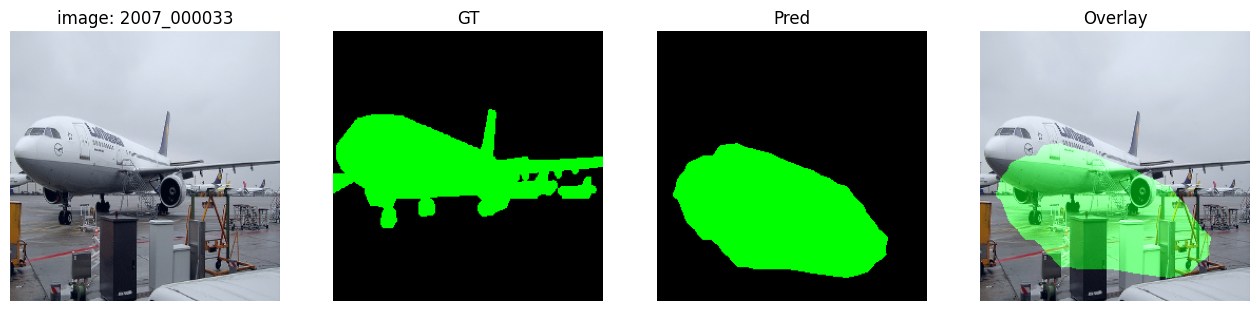

In [52]:
CKPT_PATH = RESULTS / "deeplab_binary_best.pth"
assert CKPT_PATH.exists(), f"Missing checkpoint: {CKPT_PATH}"
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.eval();

def colorize_binary(mask):
    # mask: HxW int64 (0 bg, 1 fg, 255 ignore)
    m = mask.astype(np.uint8)
    h, w = m.shape
    rgb = np.zeros((h,w,3), np.uint8)
    rgb[m==1]  = (0,255,0)      # fg = green
    rgb[m==255]= (128,128,128)  # ignore = gray
    return rgb

def get_val_sample_by_index(i=0):
    x, y, g, iD = next(iter(torch.utils.data.DataLoader(
        VOCPseudoBinary([val_ids[i]], IMG_ROOT, PSEUDO_DIR, GT_ROOT, train=False, size=IMG_SIZE),
        batch_size=1, shuffle=False)))
    return x.to(DEVICE), y.squeeze(0).cpu().numpy(), g.squeeze(0).cpu().numpy(), iD[0]

def show_pred(i=0):
    x, y_np, g_np, img_id = get_val_sample_by_index(i)
    with torch.no_grad():
        out = model(x)["out"]
        pred = out.argmax(1)[0].cpu().numpy()

    # de-normalize image for display
    x_disp = x[0].detach().cpu().numpy().transpose(1,2,0)
    x_disp = (x_disp - x_disp.min()) / (x_disp.max()-x_disp.min()+1e-8)

    fig, axs = plt.subplots(1,4, figsize=(16,4))
    axs[0].imshow(x_disp); axs[0].set_title(f"image: {img_id}"); axs[0].axis("off")
    axs[1].imshow(colorize_binary(g_np)); axs[1].set_title("GT"); axs[1].axis("off")
    axs[2].imshow(colorize_binary(pred)); axs[2].set_title("Pred"); axs[2].axis("off")
    overlay = (x_disp*255).astype(np.uint8)
    pred_rgb = colorize_binary(pred)
    blend = cv2.addWeighted(overlay, 1.0, pred_rgb, 0.5, 0)
    axs[3].imshow(blend); axs[3].set_title("Overlay"); axs[3].axis("off")
    plt.show()

show_pred(i=0)

In [53]:
import pandas as pd
import math

# perturbations
def p_blur(img):       return cv2.GaussianBlur(img, (5,5), 1.2)
def p_brightness(img): return np.clip(img*1.25, 0, 1)
def p_gauss(img):      
    n = np.random.normal(0, 0.05, img.shape).astype(np.float32)
    return np.clip(img + n, 0, 1)
def p_hflip(img):      return np.ascontiguousarray(img[:, ::-1, :])
def p_rot(img, deg=15):
    h,w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), deg, 1.0)
    return cv2.warpAffine(img, M, (w,h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

PERTS = {
    "clean":     lambda im: im,
    "blur":      p_blur,
    "brightness":p_brightness,
    "gauss":     p_gauss,
    "hflip":     p_hflip,
    "rotation":  lambda im: p_rot(im, 15),
}

def eval_perturbations(dl, perts=PERTS):
    model.eval()
    rows = []
    with torch.no_grad():
        for name, fn in perts.items():
            cm = torch.zeros(2,2, device=DEVICE)
            for x, _, g, _ in dl:
                # de-normalize to 0..1 float HxWxC
                x_np = x.cpu().numpy()
                # x is normalized; revert approx for perturb: (x*std)+mean
                mean = np.array([0.485,0.456,0.406]).reshape(1,3,1,1)
                std  = np.array([0.229,0.224,0.225]).reshape(1,3,1,1)
                im01 = (x_np*std + mean).transpose(0,2,3,1).clip(0,1)

                # apply perturb per image, then re-normalize and to tensor
                ims = []
                for i in range(im01.shape[0]):
                    z = fn(im01[i])
                    z = (z - mean[0].transpose(1,2,0)) / std[0].transpose(1,2,0)
                    z = torch.from_numpy(z.transpose(2,0,1)).float()
                    ims.append(z)
                x_per = torch.stack(ims,0).to(DEVICE, non_blocking=True)

                g = g.to(DEVICE, non_blocking=True)
                out = model(x_per)["out"]
                pred = out.argmax(1)
                cm += fast_confusion(pred, g, num_classes=2, ignore_index=IGNORE_IDX)

            ious, miou = iou_from_cm(cm)
            rows.append({"perturb": name, "IoU_bg": ious[0], "IoU_fg": ious[1], "mIoU": miou})
            print(f"{name:10s} | mIoU={miou:.3f} (bg={ious[0]:.3f}, fg={ious[1]:.3f})")

    df = pd.DataFrame(rows).sort_values("mIoU", ascending=False)
    df.to_csv(RESULTS / "voc_val_robustness.csv", index=False)
    print("Saved:", (RESULTS / "voc_val_robustness.csv").resolve())
    return df

# run on full validation set
df_rob = eval_perturbations(val_dl)
df_rob

clean      | mIoU=0.538 (bg=0.717, fg=0.358)
blur       | mIoU=0.514 (bg=0.719, fg=0.308)
brightness | mIoU=0.542 (bg=0.715, fg=0.370)
gauss      | mIoU=0.525 (bg=0.720, fg=0.329)
hflip      | mIoU=0.504 (bg=0.693, fg=0.314)
rotation   | mIoU=0.524 (bg=0.715, fg=0.333)
Saved: /kaggle/working/outputs/voc_val_robustness.csv


,perturb,IoU_bg,IoU_fg,mIoU
2,brightness,0.715028,0.369855,0.542442
0,clean,0.717362,0.357663,0.537513
3,gauss,0.720337,0.328694,0.524516
5,rotation,0.715343,0.332732,0.524037
1,blur,0.719178,0.308401,0.513790
4,hflip,0.693372,0.314209,0.503791


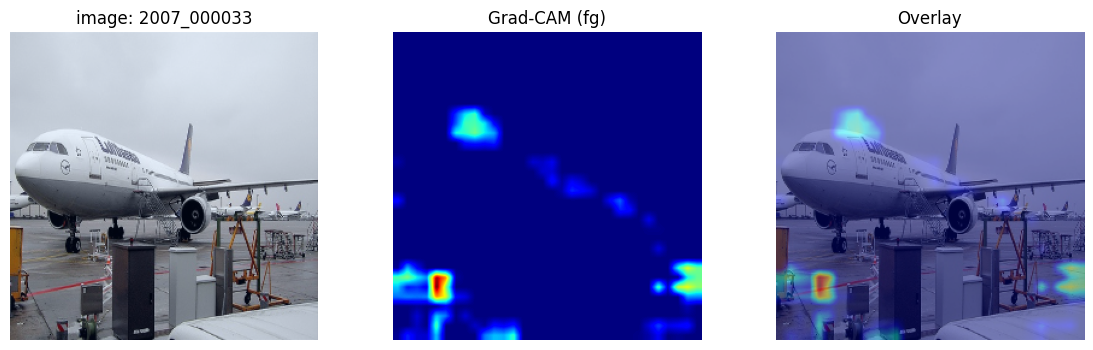

In [54]:
# Grad-CAM on final conv (layer4) toward foreground (class 1) 
import torch
import torch.nn.functional as F

target_layer = model.backbone.layer4[-1].conv3  # last conv in layer4
feats = []
grads = []

def _f_hook(m, i, o): feats.append(o.detach())
def _b_hook(m, gi, go): grads.append(go[0].detach())

h1 = target_layer.register_forward_hook(_f_hook)
h2 = target_layer.register_full_backward_hook(_b_hook)

def gradcam_on_index(i=0):
    model.zero_grad(set_to_none=True)
    x, y_np, g_np, img_id = get_val_sample_by_index(i)
    x.requires_grad_(True)

    out = model(x)["out"]            # Bx2xHxW
    # target foreground score (sum over spatial map)
    score = out[:,1].sum()
    score.backward()

    fmap = feats[-1][0]              # CxHf x Wf
    grad = grads[-1][0]              # CxHf x Wf
    weights = grad.mean(dim=(1,2), keepdim=True)   # Cx1x1
    cam = (weights * fmap).sum(0)                   # Hf x Wf
    cam = F.relu(cam)
    cam = cam / (cam.max() + 1e-8)
    cam = F.interpolate(cam[None,None], size=(IMG_SIZE, IMG_SIZE), mode="bilinear", align_corners=False)[0,0].cpu().numpy()

    # de-normalize image for display
    x_disp = x[0].detach().cpu().numpy().transpose(1,2,0)
    x_disp = (x_disp - x_disp.min()) / (x_disp.max()-x_disp.min()+1e-8)

    heat = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted((x_disp*255).astype(np.uint8), 0.6, heat, 0.4, 0)

    fig, axs = plt.subplots(1,3, figsize=(14,4))
    axs[0].imshow(x_disp); axs[0].set_title(f"image: {img_id}"); axs[0].axis("off")
    axs[1].imshow(cam, cmap="jet"); axs[1].set_title("Grad-CAM (fg)"); axs[1].axis("off")
    axs[2].imshow(overlay); axs[2].set_title("Overlay"); axs[2].axis("off")
    plt.show()

# example
gradcam_on_index(0)

# clean up hooks if you’re done
h1.remove(); h2.remove()
feats.clear(); grads.clear();